# Intercorrélation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

#import matplotlib as mpl
#mpl.rcParams['axes.grid'] = True
#mpl.rcParams['text.usetex'] = True
#mpl.rcParams['font.size'] = 16

## Communications numériques

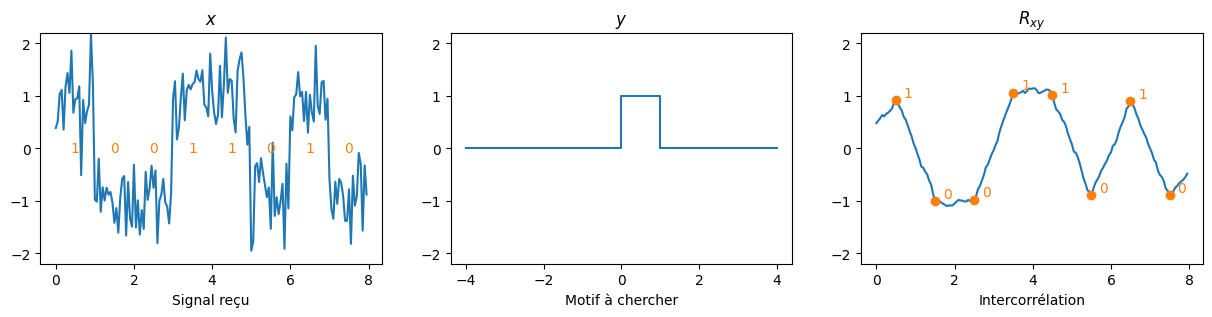

In [2]:
# Initialisation de l'affichage
ylim = [-2.2, 2.2]
fig, axs = plt.subplots(1, 3, figsize=(15,3))

# Message
msg = np.array([1, 0, 0, 1, 1, 0, 1, 0])
M = len(msg)

# Temps & instants d'échantillonnage
Fe = 20
n = np.arange(0, M, 1/Fe)
idx = np.arange(M)*Fe + Fe//2

# Forme d'onde
h = np.ones(Fe)

# Signal émis
x = np.kron(2*msg-1, h)

# Signal reçu (bruité)
b = np.random.normal(0, .5, x.shape)
y = x + b
axs[0].plot(n,y)
for i in range(M):
    axs[0].text(n[idx[i]], 0, msg[i], ha="center", va="center", color="C1")
axs[0].set_title('$x$')
axs[0].set_xlabel('Signal reçu')
axs[0].set_ylim(ylim)

# Forme d'onde (graphique)
axs[1].plot([-4, 0, 0, 1, 1, 4], [0, 0, 1, 1, 0, 0])
axs[1].set_title('$y$')
axs[1].set_xlabel('Motif à chercher')
axs[1].set_ylim(ylim)

# Intercorrélation
z = np.correlate(y, h/Fe, mode="same")
axs[2].plot(n, z)
for i in range(M):
    axs[2].plot(n[idx[i]], z[idx[i]], "C1o")
    axs[2].text(n[idx[i]]+.2, z[idx[i]], msg[i], ha="left", va="bottom", color="C1")
axs[2].set_title("$R_{xy}$")
axs[2].set_xlabel('Intercorrélation')
axs[2].set_ylim(ylim)

plt.savefig("communications.svg", bbox_inches="tight")

## Intercorrélation avec une sinusoïde

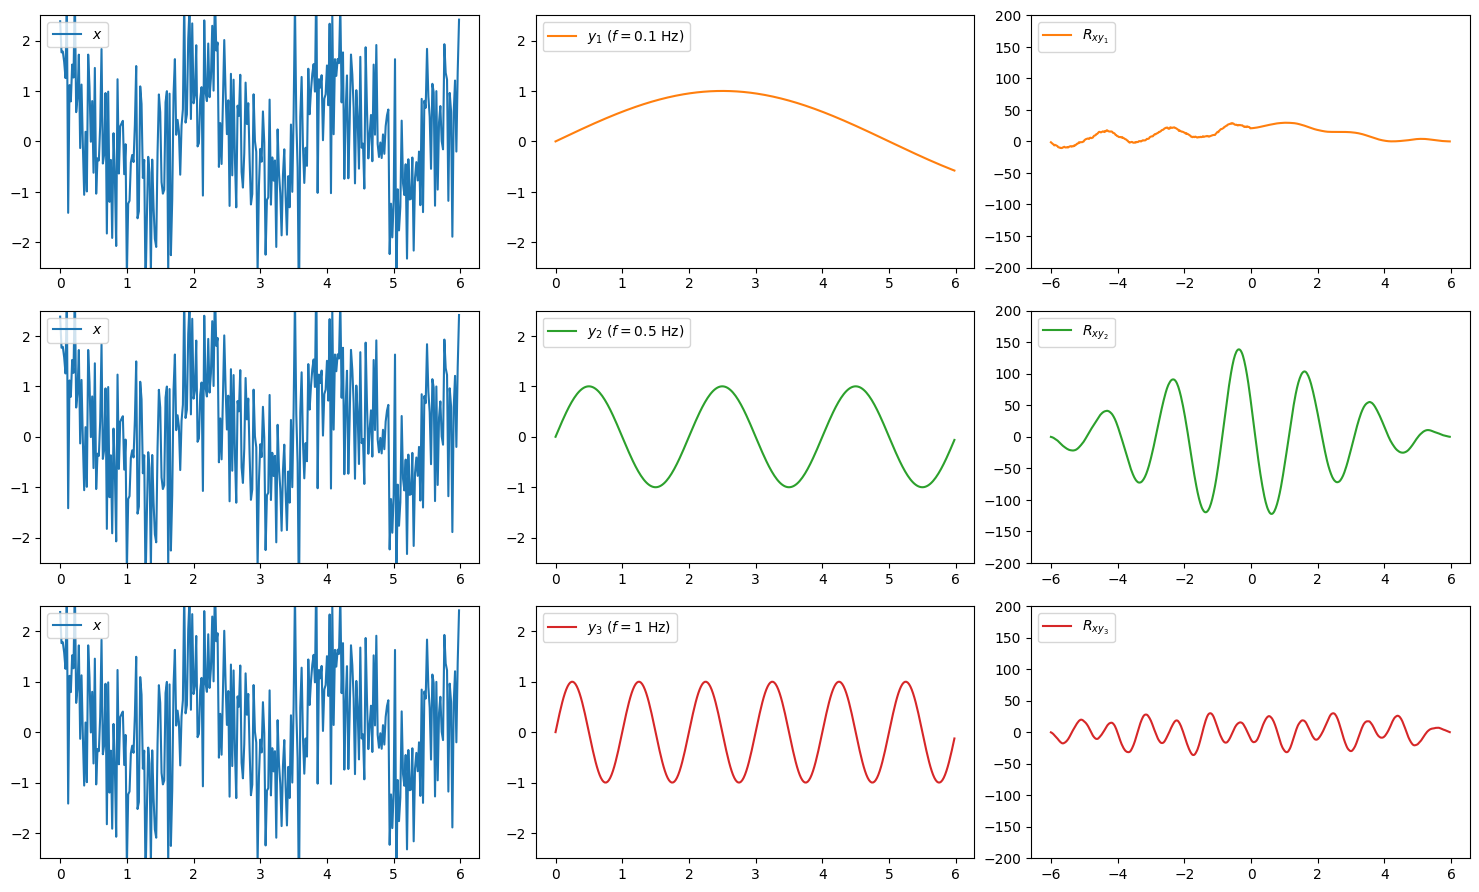

In [3]:
# Fréquences
freqs = [.1, .5, 1]

# Temps
N = 300
Te = 1/50
t = np.arange(0,N) * Te
u = np.arange(-N,N-1) * Te

# Signal bruité
x = np.sin(2*np.pi*freqs[1]*t + 1)
b = np.random.normal(0, 1, x.shape)
y = x + b

# Initialisation de l'affichage
ylim = [-2.5, 2.5]
fig, axs = plt.subplots(3, 3, figsize=(15,9))
fig.tight_layout(pad=1.0)

for i in range(3):
    
    f = freqs[i]
    
    # Signal x
    axs[i][0].plot(t, y, label='$x$', color='C0')
    
    # Signal y
    w = np.sin(2*np.pi*f*t)
    axs[i][1].plot(t, w, label=f'$y_{i+1}$ ($f={f}$ Hz)', color=f'C{i+1}')
    
    # Intercorrélation
    z = np.correlate(y, w, mode="full")
    axs[i][2].plot(u,z, label=f'$R_{{xy_{i+1}}}$', color=f'C{i+1}')
    axs[i][2].set_ylim([-200, 200])
    
    for j in range(2):
        axs[i][j].set_ylim(ylim)
    for j in range(3):
        axs[i][j].legend(loc='upper left')

plt.savefig("sinusoide.svg", bbox_inches='tight')

## Estimation d'un écho

On commence par définir les conditions expérimentales.

In [4]:
# Atténuation
a = 0.5

# Retard (en secondes)
d = 0.3

 Signal émis (bruit blanc) :

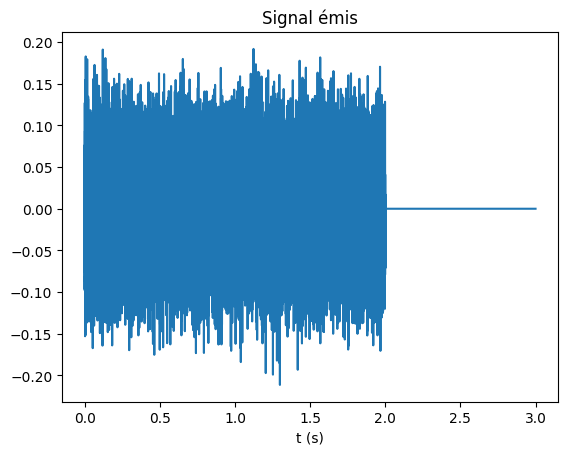

In [5]:
# Fréquence et période d'échantillonnage
fe = 22e3
Te = 1/fe

# Nombre de points
N = int(fe)

# Son (avec une seconde de silence ensuite)
s = np.random.randn(2*N) * .05
s = np.concatenate([s, np.zeros(N)])

N = len(s)
n = np.arange(N)
t = (n-1)*Te

# Affichage
plt.figure()
plt.plot(t,s)
plt.xlabel('t (s)')
plt.title('Signal émis')
plt.show()

# Ecoute
Audio(s, rate=fe)

Signal reçu

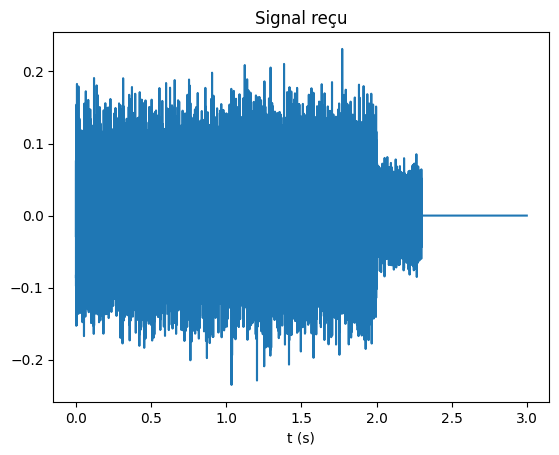

In [6]:
# Retard (en échantillons)
D = int(d/Te)

# Signal réfléchi (seul)
reflected = np.concatenate([np.zeros(D), s])
reflected = a * reflected[:N]

# Signal reçu (direct + réfléchi)
x = s + reflected

# Affichage
plt.figure()
plt.plot(t,x)
plt.xlabel('t (s)')
plt.title('Signal reçu')
plt.show()

# Ecoute
Audio(x, rate=fe)

Autocorrélation

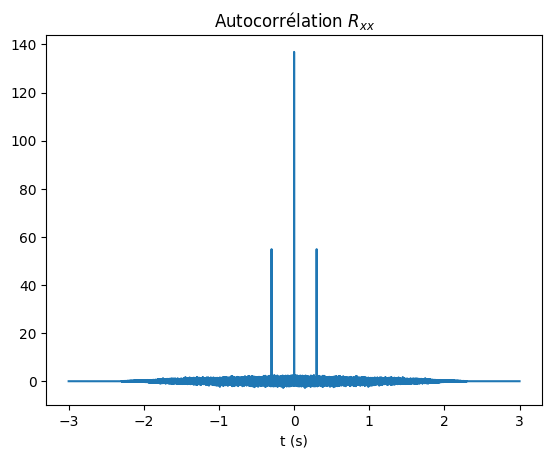

In [7]:
# Autocorrélation
c = np.correlate(x, x, mode="full")
n = np.arange(-N,N-1)

# Affichage
plt.figure()
plt.plot(n*Te,c)
plt.xlabel('t (s)')
plt.title('Autocorrélation $R_{xx}$')
plt.show()

On peut maintenant chercher les pics, et déterminer à partir ce ceux-ci les paramètres de l'écho

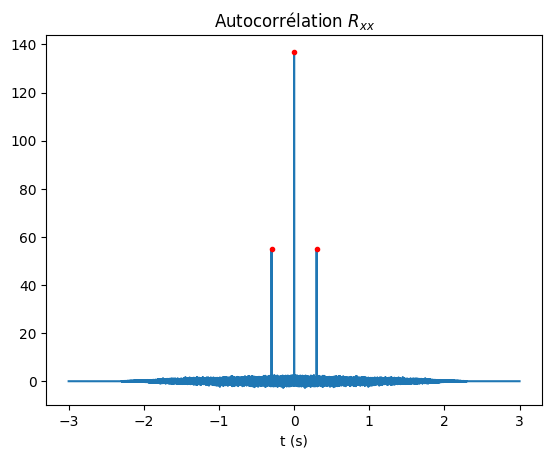

Premier maximum en -0.00 s égal à 136.91
Second maximum en  0.30 s égal à 54.90
Donc d = 0.30 s et a = 0.50


In [8]:
# Recherche des pics
from scipy.signal import find_peaks
peaks, props = find_peaks(c, distance=4000, height=10)

# Affichage des pics sur l'autocorrélation
plt.figure()
plt.plot(n*Te,c)
plt.xlabel('t (s)')
plt.title('Autocorrélation $R_{xx}$')
plt.plot(n[peaks]*Te, c[peaks], 'r.');
plt.show()

# Décalages des pics
t_direct = n[peaks[1]]*Te
t_reflected = n[peaks[2]]*Te

# Amplitude des pics
h_direct = c[peaks[1]]
h_reflected = c[peaks[2]]

# Paramètres
delta = h_direct**2 - 4*h_reflected**2
aest = (h_direct-np.sqrt(delta)) / (2*h_reflected)

# Affichage
print(f'Premier maximum en {t_direct:.2f} s égal à {h_direct:.2f}')
print(f'Second maximum en  {t_reflected:.2f} s égal à {h_reflected:.2f}')
print(f'Donc d = {t_reflected:.2f} s et a = {aest:.2f}')